# Single channel recordings

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
from glob import glob
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from single_channel_analysis import *
update_plot_defaults()

%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/Single_channels" folder

In [2]:
pathToData = "data/Single_channels"
abf_files = glob(pathToData+"/*.abf")
abf_files

['data/Single_channels/2024_06_11_0003.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/Single_channels/2024_06_11_0003.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(1, 2, 1154560)
sampling freq: 10000.0 Hz


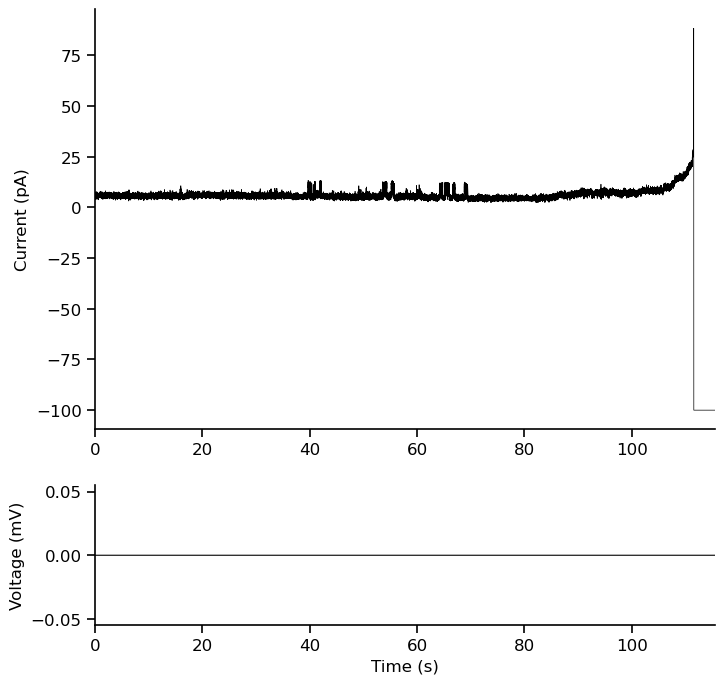

In [4]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")
current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
ax[1].set_xlabel("Time (s)")
plt.show()

## 2. Select what you want to measure

### Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

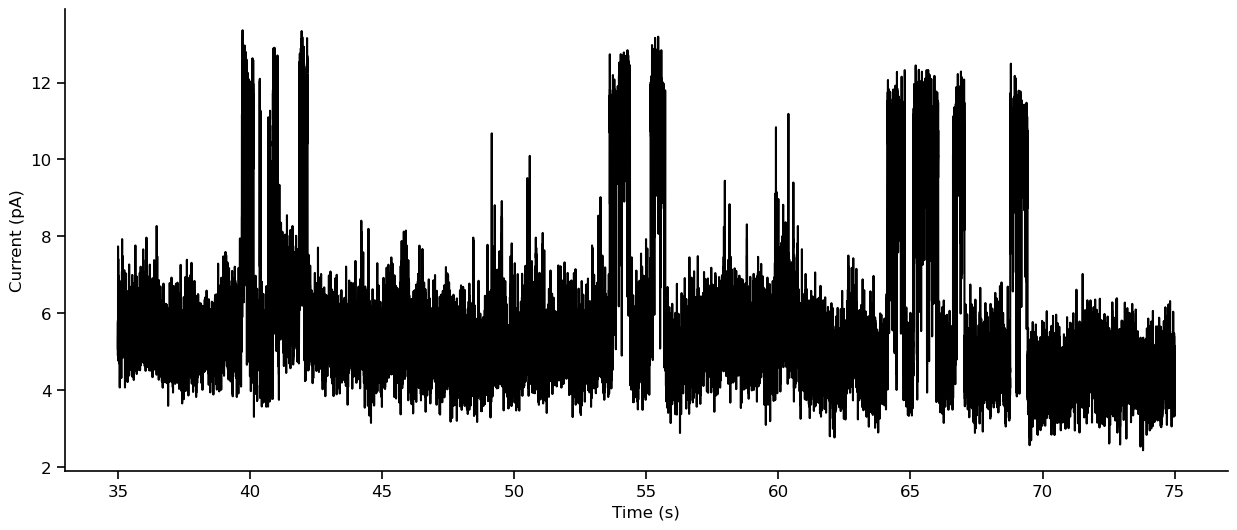

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 35  # seconds
end_time = 75   # seconds

current_traces, time = select_sweep_window(sweeps, sweeps_time, start_time*1000, end_time*1000, sampling_freq, channel=0)
time /= 1000 # Convert to Seconds

fig, ax = plt.subplots(figsize=(15, 6), linewidth=0.1)
ax.plot(time, current_traces[0], color='k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (pA)')
plt.show()

## 3. Signal processing

### 3.1. Highpass filter the current trace

To remove the baseline and any slow drift in the current trace

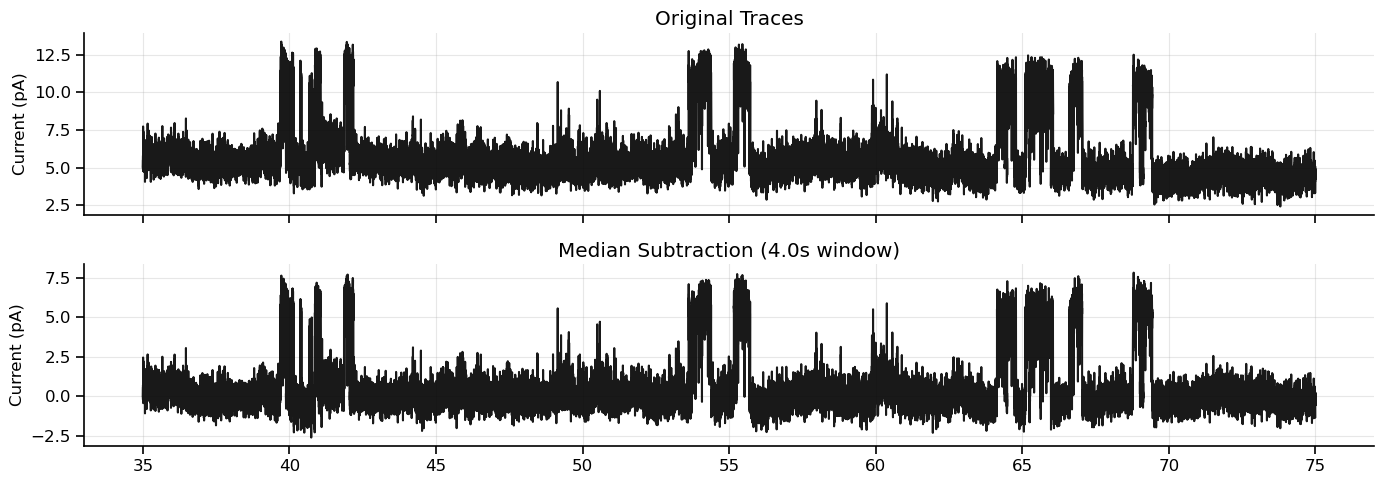

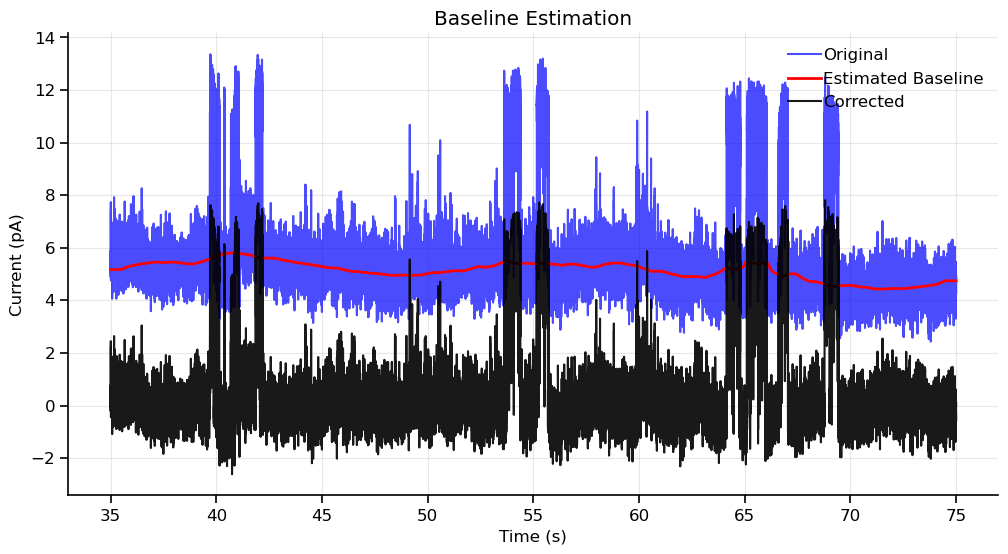

In [6]:
# # Basic usage with auto-detection of line frequency
# filtered, noise = remove_line_noise(current_traces, sampling_freq=sampling_freq)

# Specify 60Hz filtering with 3 harmonics and visualization
filtered, noise = remove_line_noise(current_traces, 
                                        sampling_freq=sampling_freq,
                                        target_freq=60, 
                                        harmonics=3, 
                                        plot_spectrum=False)

# Median baseline subtraction
window_size_ms = 4000
corrected_median, baseline_median = baseline_correction(filtered, sampling_freq, method='median_subtraction', window_ms=window_size_ms)

# # Use FFT-based filtering for sharper frequency cutoffs
# filtered_data, noise = remove_line_noise(
#     my_recording, 
#     sampling_freq=10000, 
#     method='fft', 
#     bandwidth=1.0  # Narrower bandwidth for more precise filtering
# )

# # Use Butterworth bandstop with custom filter order
# filtered_data, noise = remove_line_noise(
#     my_recording, 
#     sampling_freq=10000, 
#     method='bandstop', 
#     filter_order=6  # Higher order for steeper roll-off
# )

# ---------------------------------------------------------------------------------------------------------------
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
axes[0].plot(time, current_traces.T, alpha=0.9, color='black')
axes[0].set_ylabel('Current (pA)')
axes[0].set_title('Original Traces')
axes[0].grid(True, alpha=0.3)
axes[1].plot(time, corrected_median.T, alpha=0.9, color='black')
axes[1].set_ylabel('Current (pA)')
axes[1].set_title(f'Median Subtraction ({window_size_ms/1000}s window)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show baseline estimation for median method
fig, ax = plt.subplots(figsize=(12, 6))
trace_idx = 0  # Show first trace
ax.plot(time, current_traces[trace_idx], 'b-', alpha=0.7, label='Original')
ax.plot(time, baseline_median[trace_idx], 'r-', linewidth=2, label='Estimated Baseline')
ax.plot(time, corrected_median[trace_idx], 'k-', alpha=0.9, label='Corrected')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (pA)')
ax.set_title('Baseline Estimation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### 3.2. Lowpass filter the recording

To remove high frequency noise

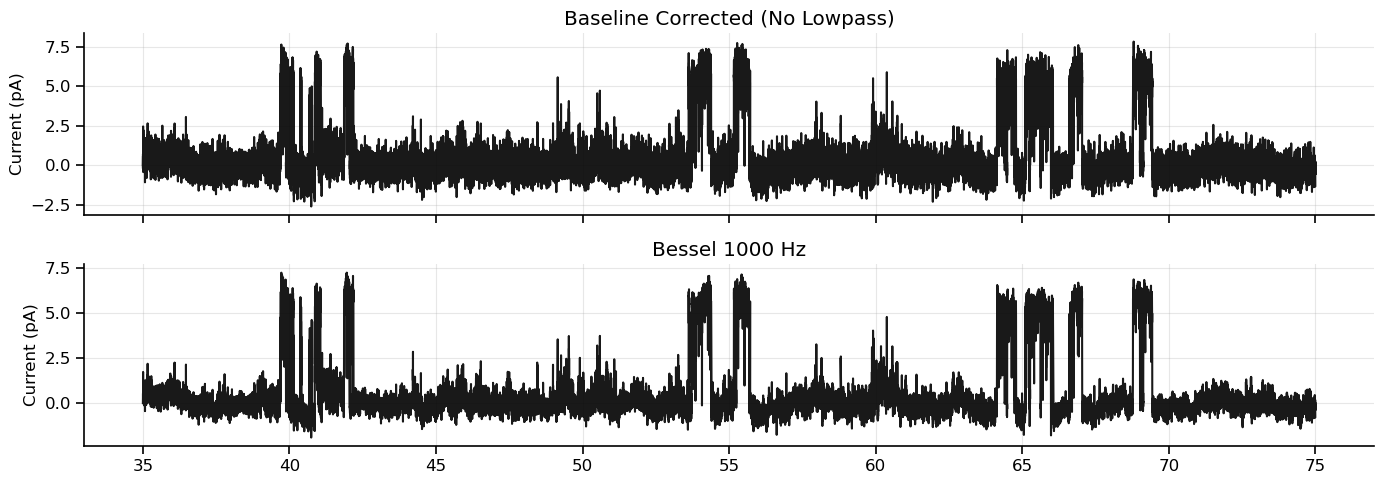

In [7]:
# Lowpass filtering
cutoff = 1000
baseline_corrected = corrected_median 

filtered_traces = lowpass_filter(baseline_corrected, cutoff, sampling_freq, filter_type='bessel')

# Plot filter comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
axes[0].plot(time, baseline_corrected.T, alpha=0.9, color='black')
axes[0].set_title('Baseline Corrected (No Lowpass)')
axes[0].set_ylabel('Current (pA)')
axes[0].grid(True, alpha=0.3)
axes[1].plot(time, filtered_traces.T, alpha=0.9, color='black')
axes[1].set_title(f'Bessel {cutoff} Hz')
axes[1].set_ylabel('Current (pA)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3. Detect the number of distinct levels (channel opening states)

Using provided mean guesses: [0, 10]


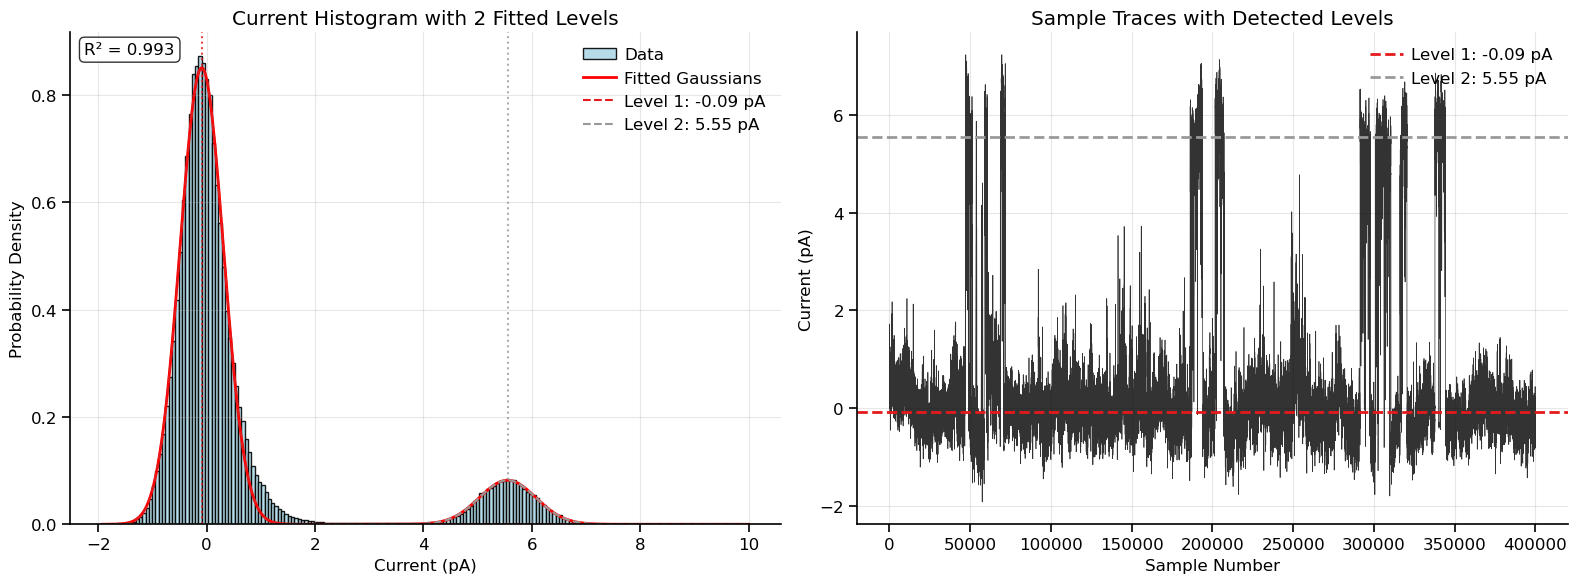


=== LEVEL DETECTION RESULTS ===
Detected 2 current levels:
  Level 1: -0.091 pA
  Level 2: 5.553 pA
Fit quality (R²): 0.993
Standard deviations: ['0.401', '0.521']

Baseline level: -0.091 pA
Levels above baseline: ['5.553'] pA


In [8]:
# Detect levels automatically by fitting Gaussian distributions to the histogram
detected_levels, fit_info = detect_levels_from_histogram(filtered_traces, 
                                                         n_levels=2,  # Specify number of levels (baseline + open levels)
                                                         mean_guesses=[0, 10],
                                                         plot_result=True, bins=150)

# The baseline will be the lowest detected level
baseline_level = detected_levels[0]
current_levels_above_baseline = detected_levels[1:]  # Levels above baseline

print(f"\nBaseline level: {baseline_level:.3f} pA")
print(f"Levels above baseline: {[f'{level:.3f}' for level in current_levels_above_baseline]} pA")

### 3.4. Detect channel open/close events and idealize single-channel behavior

In [9]:
# # If the automatic gaussian fit fails to detect the levels correctly, you can manually set the levels
# current_levels_above_baseline = [150]

In [10]:
# Initialize detector with your filtered traces
time_seconds = time / 1000  # Convert time from milliseconds to seconds
detector = MultiLevelEventDetector(filtered_traces, time_seconds, sampling_freq)

detector.baseline_level = baseline_level
detector.set_current_levels(current_levels_above_baseline)

Set 1 current levels:
  L1: 5.55 pA
Detection thresholds: ['2.73'] pA


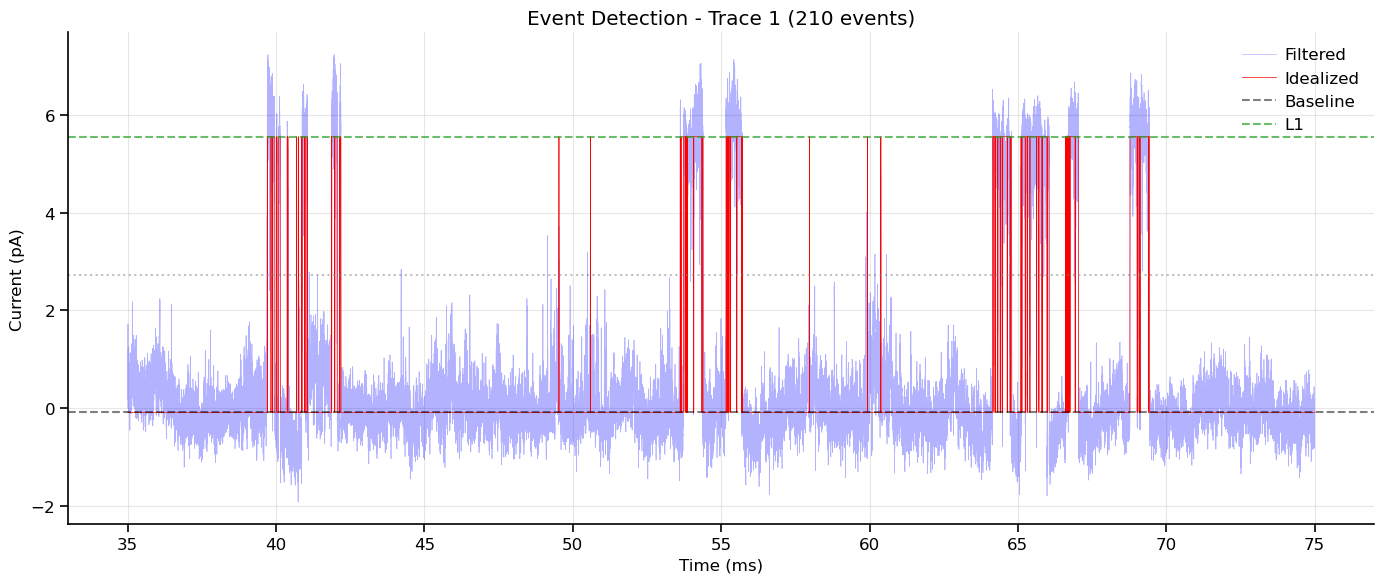

Found 210 events in trace 1
First few events:
  Event 1: 35.0-39.7 ms, Baseline, 4.70 ms duration
  Event 2: 39.7-39.7 ms, Baseline, 0.00 ms duration
  Event 3: 39.7-39.7 ms, L1, 0.00 ms duration
  Event 4: 39.7-39.7 ms, Baseline, 0.00 ms duration
  Event 5: 39.7-39.7 ms, L1, 0.00 ms duration

To process all traces, run: detector.detect_all_events()
To adjust levels, run: detector.set_current_levels([level1, level2, ...])


In [11]:
# Set detection parameters
detector.min_event_duration = 0.6  # ms - adjust based on your channel kinetics
detector.hysteresis_factor = 0.15  # Prevent signal noise from causing rapid flickering between levels by adding a small "momentum" to the threshold

# Test event detection of the first trace
events_trace1, idealized_trace1 = detector.detect_events_single_trace(0, plot_result=True)

# ---------------------------------------------------------------------
# Print the results
print(f"Found {len(events_trace1)} events in trace 1")
if events_trace1:
    print("First few events:")
    for i, event in enumerate(events_trace1[:5]):
        start_ms, end_ms, level_idx, amplitude = event
        level_name = detector.level_names[level_idx-1] if level_idx > 0 else 'Baseline'
        duration_ms = (end_ms - start_ms) * 1000
        print(f"  Event {i+1}: {start_ms*1000:.1f}-{end_ms*1000:.1f} ms, {level_name}, {duration_ms:.2f} ms duration")
print(f"\nTo process all traces, run: detector.detect_all_events()")
print(f"To adjust levels, run: detector.set_current_levels([level1, level2, ...])")


Processing 1 traces...


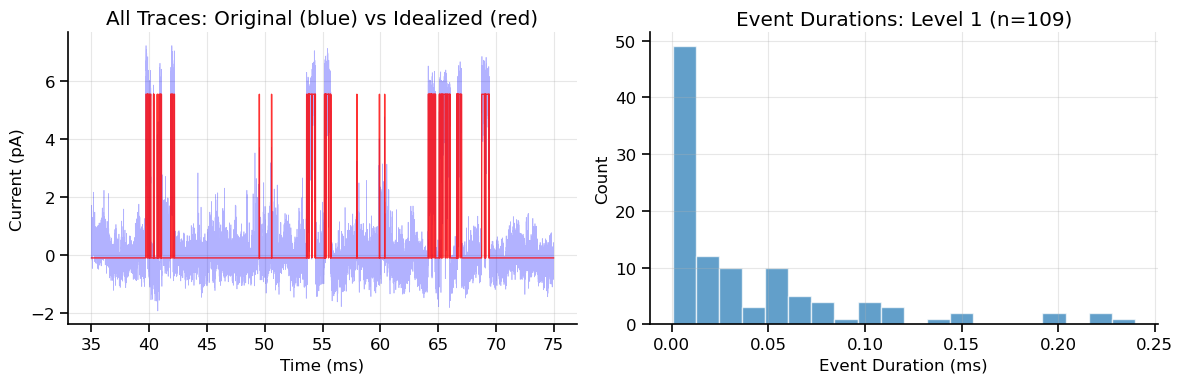

In [12]:
events_all, idealized_traces = detector.detect_all_events(plot_summary=True, duration_hist_bins=20)

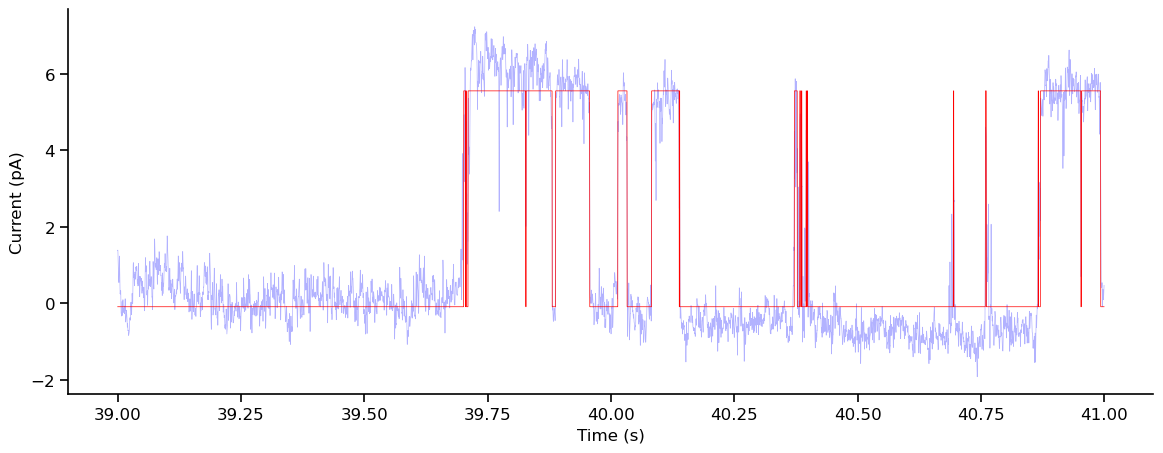

In [13]:
# Zoom in on part of the trace to check if idealization is good
start_time = 39.   # in seconds
end_time = 41      # in seconds

# -----------------------------------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 5))
t0 = time[0]
start_idx = time_to_index(start_time-t0, sampling_freq) *1000
end_idx = time_to_index(end_time-t0, sampling_freq) *1000
ax.plot(time[start_idx:end_idx], detector.traces[trace_idx, start_idx:end_idx], 'b-', alpha=0.3, linewidth=0.5, label='Filtered')
ax.plot(time[start_idx:end_idx], detector.idealized_traces[trace_idx, start_idx:end_idx], 'r-', linewidth=0.5, label='Idealized')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (pA)')
plt.show()


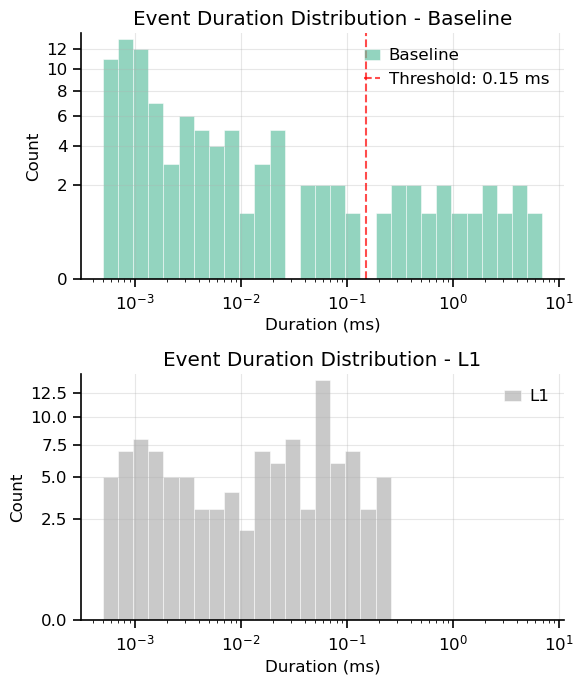

In [14]:
# Based on the histogram of closed durations, determine a threshold for burst separation
closed_threshold = 0.15  # ms - adjust based on your histogram

durations = detector.plot_duration_histogram(bins=30, threshold=closed_threshold,
                                             fit_gaussian=False,
                                             log_x=True, sqrt_y_scale=True,
                                             separate_plots=True)

Burst Analysis (threshold: 0.15 ms)
Number of bursts: 15
Mean burst duration: 0.35 ms
Mean Po within bursts: 0.7318


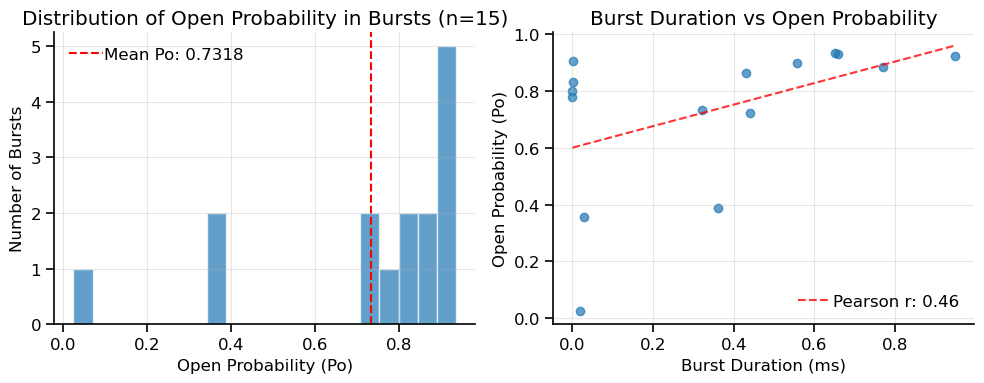

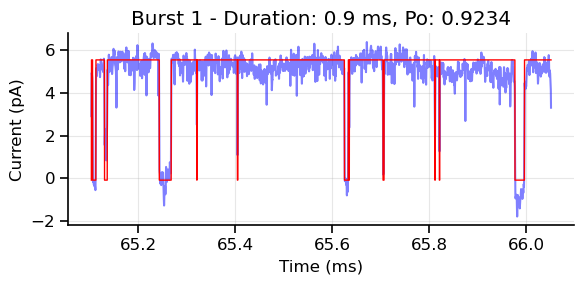

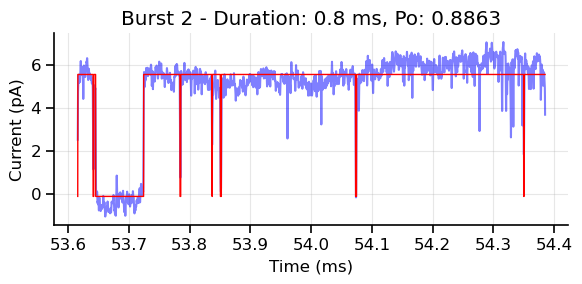

In [15]:
# Analyze bursts
burst_data, burst_summary = detector.analyze_bursts(closed_threshold)

# Plot burst analysis
detector.plot_burst_analysis(burst_data)


# # Print summary statistics
# print(f"Overall Po (across all data): {po_overall:.4f}")
# print(f"Po within bursts: {burst_summary['overall_po_in_bursts']:.4f}")

In [16]:
# Generate comprehensive report
detector.generate_analysis_report()
# Prints everything: Po, mean durations, event counts, etc.

SINGLE-CHANNEL ANALYSIS REPORT

BASIC STATISTICS:
  Number of traces: 1
  Total events detected: 210
  Events per trace: 210.0 ± 0.0

CURRENT LEVELS:
  Baseline: -0.09 pA
  L1: 5.55 pA

OPEN PROBABILITY:
  Mean P(open): 0.7318 (73.18%)

EVENT DURATIONS:
  Baseline: 0.35 ± 1.12 ms (median: 0.00 ms, n=101)
  L1: 0.04 ± 0.05 ms (median: 0.02 ms, n=109)
